# Generate Charrassin bathy on 8km grid

copied from Ezhil: https://github.com/ezhilsabareesh8/Notebooks/blob/main/Regridd_Charrassin_topo_to_model_grid.ipynb

Data: https://datadryad.org/dataset/doi:10.5061/dryad.rbnzs7hkc


In [1]:
import xesmf
import xarray as xr
import os
import cmocean as cm
import cartopy.crs as ccrs
import cosima_cookbook as cc
from dask.distributed import Client
import dask.array as da
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt

from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326", always_xy=True) 
#

```
Download: 
ICE_THICKNESS_ANTGG2022.tif
MASK_ANTGG2022.tif
BED_ANTGG2022.tif

In [2]:
# Open dataset
dataset = gdal.Open('/g/data/x77/cy8964/Charrassin2025_Data/BED_ANTGG2022.tif')
band = dataset.GetRasterBand(1)
data = band.ReadAsArray()

# Get GeoTransform and projection
gt = dataset.GetGeoTransform()
nx, ny = dataset.RasterXSize, dataset.RasterYSize

# Build coordinates from geotransform
x = np.arange(gt[0], gt[0] + nx * gt[1], gt[1])
y = np.arange(gt[3], gt[3] + ny * gt[5], gt[5])

# y is descending if gt[5] < 0 (common for north-up images), reverse if needed
if gt[5] < 0:
    y = y[::-1]
    data = data[::-1, :]  # Flip data accordingly

In [3]:
# print("Driver: ", ds.GetDriver().ShortName)
# print("Size: ", ds.RasterXSize, ds.RasterYSize)
# print("Bands: ", ds.RasterCount)
# print("Projection: ", ds.GetProjection())
# print("GeoTransform: ", ds.GetGeoTransform())

In [4]:
da = xr.DataArray(
    data,
    dims=('y', 'x'),
    coords={'x': x, 'y': y},
    attrs={
        'crs': dataset.GetProjection(),
        'transform': gt,
        'nodata': band.GetNoDataValue()
    }
)

In [5]:
ds_xr = xr.Dataset({'elevation': da})


In [6]:
BedMachine_v3 = xr.open_dataset('/g/data/x77/cy8964/satellite-meltrate/Adusumilli/BedMachineAntarctica-v3.nc')
BedMachine_v3#.bed.plot()

<xarray.Dataset> Size: 4GB
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 53kB -3333000 -3332500 -3332000 ... 3332500 3333000
  * y          (y) int32 53kB 3333000 3332500 3332000 ... -3332500 -3333000
Data variables:
    mapping    |S1 1B ...
    mask       (y, x) int8 178MB ...
    firn       (y, x) float32 711MB ...
    surface    (y, x) float32 711MB ...
    thickness  (y, x) float32 711MB ...
    bed        (y, x) float32 711MB ...
    errbed     (y, x) float32 711MB ...
    source     (y, x) int8 178MB ...
    dataid     (y, x) int8 178MB ...
    geoid      (y, x) int16 356MB ...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

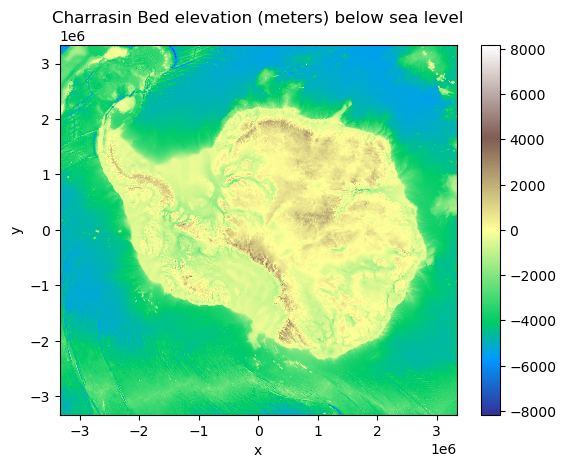

In [8]:
da.plot(cmap='terrain')
plt.title("Charrasin Bed elevation (meters) below sea level")
#plt.savefig("/g/data1a/tm70/ek4684/Bedmachine_data/Charrasin_BED_elevation.png", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Create 2D coordinate grids
X, Y = np.meshgrid(x, y)

# Flatten and transform
lon_flat, lat_flat = ps_to_ll.transform(X.ravel(), Y.ravel())
lon_flat = (lon_flat + 280) % 360 - 280  # Normalize longitudes

# Reshape to 2D
new_longitudes = lon_flat.reshape(X.shape)
new_latitudes = lat_flat.reshape(Y.shape)

In [10]:
ds_out = xr.Dataset(
    data_vars={
        "elevation": (("y", "x"), ds_xr.elevation.data)
    },
    coords={
        "lat": (("y", "x"), new_latitudes),
        "lon": (("y", "x"), new_longitudes)
    },
    attrs={
        "title": "Bedmachine Antarctic Topography",
        "source_crs": "EPSG:3031",
        "converted_to": "EPSG:4326",
        "note": "Original Charrassin Bed elevation data was in polar stereographic projection and converted to lat/lon."
    }
)

ds_out["elevation"].attrs["units"] = "meters"
ds_out["elevation"].attrs["long_name"] = "Surface elevation"
ds_out["lat"].attrs["units"] = "degrees_north"
ds_out["lon"].attrs["units"] = "degrees_east"
#ds_out.to_netcdf("/g/data/x77/cy8964/Charrassin2025_Data/BED_ANTGG2022_lat_lon.nc")

### Now regrid

first create weights using interactive gadi job (to allow more memory)

this took ~10 mins

```

qsub -I -P x77 -q hugemem -l ncpus=192,mem=5880G,walltime=05:00:00,storage=gdata/hh5+gdata/ik11+gdata/x77+gdata/vk83
module load esmf/8.6.1 openmpi/4.1.7


mpirun -np 192 ESMF_RegridWeightGen -p none -i --ignore_degenerate -s /g/data/x77/cy8964/Charrassin2025_Data/BED_ANTGG2022_lat_lon.nc -d /g/data/x77/ahg157/inputs/mom6/global-8km/topog.nc -w /g/data/x77/cy8964/mom6/input/input-8km/Regridd_Charrassin_to_8km_global_grid_Bilinear.nc -m bilinear --netcdf4 --src_regional --check

In [2]:
topog = xr.open_dataset('/g/data/x77/ahg157/inputs/mom6/global-8km/topog.nc', decode_times=False).rename({'geolon_t': 'lon', 'geolat_t': 'lat'})


In [3]:
Charrassin_Bed_elevation_data = xr.open_dataset('/g/data/x77/cy8964/Charrassin2025_Data/BED_ANTGG2022_lat_lon.nc', decode_times=False)


In [4]:
#Re-using the weights created for Bedmachine_v3 to model grid, since both the Charrassin and Bedmachine_v3 has same resolution (500m*500m) and same projection EPSG3031.
regridder_Bed_machine_to_GEBCO = xesmf.Regridder(
    Charrassin_Bed_elevation_data,
    topog,
    "bilinear",
    periodic=True,
    filename='/g/data/x77/cy8964/mom6/input/input-8km/Regridd_Charrassin_to_8km_global_grid_Bilinear.nc',
    reuse_weights=True)

[gadi-cpu-bdw-0153.gadi.nci.org.au:489846] shmem: mmap: an error occurred while determining whether or not /jobfs/141861485.gadi-pbs/ompi.gadi-cpu-bdw-0153.15495/jf.0/3260153856/shared_mem_cuda_pool.gadi-cpu-bdw-0153 could be created.
[gadi-cpu-bdw-0153.gadi.nci.org.au:489846] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [5]:
Elevation = regridder_Bed_machine_to_GEBCO(Charrassin_Bed_elevation_data.elevation)
#Elevation = Elevation.where(Elevation.lat <= -60, drop=True)


In [6]:
Elevation = Elevation.assign_coords(lat=topog['lat'], lon=topog['lon'])


In [7]:
#Elevation = Elevation*0 + Elevation.values[:,::-1]

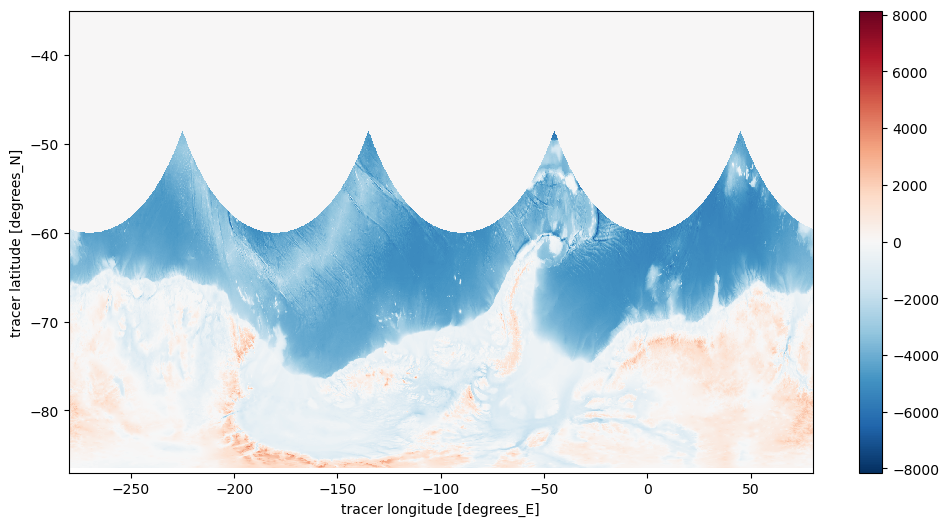

In [8]:
plt.figure(figsize=(12, 6))# You can adjust the width (12) and height (6) as needed
Elevation.plot(x='lon', y='lat')
plt.ylim(-87,-35)
#plt.savefig("/g/data1a/tm70/ek4684/Bedmachine_data/elevation_from_Charrassin_on_model_grid.png", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# now fill with GEBCO (topog.nc) data

Elevation_filled = Elevation - topog.depth.where(Elevation >=0).fillna(0)
Elevation_filled

<xarray.DataArray (ny: 3672, nx: 4320)> Size: 63MB
array([[-26.02308  , -28.326632 , -30.561165 , ..., -18.785091 ,
        -21.068981 , -23.521486 ],
       [-16.18179  , -19.316227 , -21.292469 , ...,  -9.879017 ,
        -11.79247  , -13.950594 ],
       [ -7.522543 ,  -9.362802 , -11.633567 , ...,  -2.2865865,
         -4.001109 ,  -5.678503 ],
       ...,
       [  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ]], dtype=float32)
Coordinates:
    lat      (ny, nx) float32 63MB -86.49 -86.49 -86.49 ... 65.09 65.05 65.02
    lon      (ny, nx) float32 63MB -280.0 -279.9 -279.8 ... 80.0 80.0 80.0
Dimensions without coordinates: ny, nx

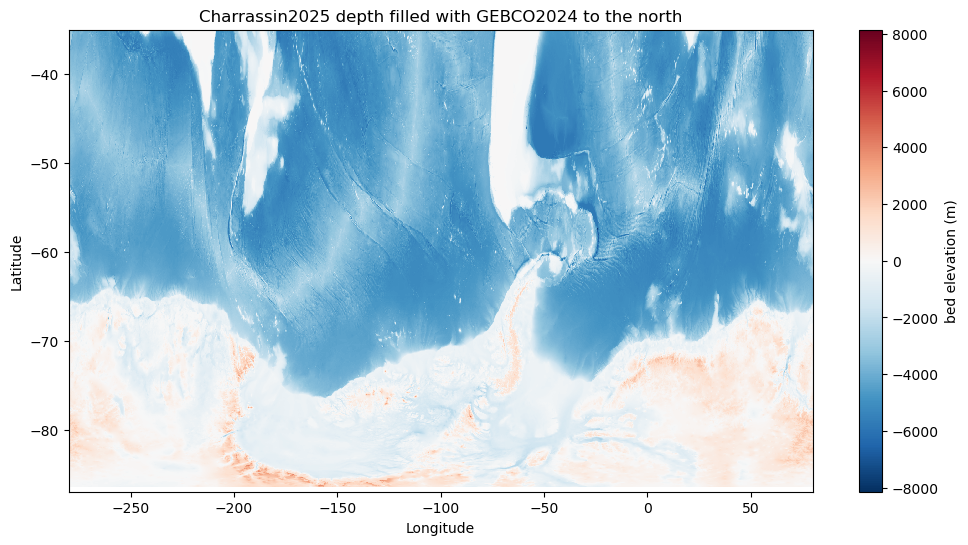

In [10]:
plt.figure(figsize=(12, 6))# You can adjust the width (12) and height (6) as needed
(Elevation_filled).plot(x='lon', y='lat', cbar_kwargs = {'label':'bed elevation (m)'})
plt.ylim(-87,-35)
#plt.savefig("/g/data1a/tm70/ek4684/Bedmachine_data/elevation_from_Charrassin_on_model_grid.png", dpi=300, bbox_inches='tight')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Charrassin2025 depth filled with GEBCO2024 to the north')
plt.show()

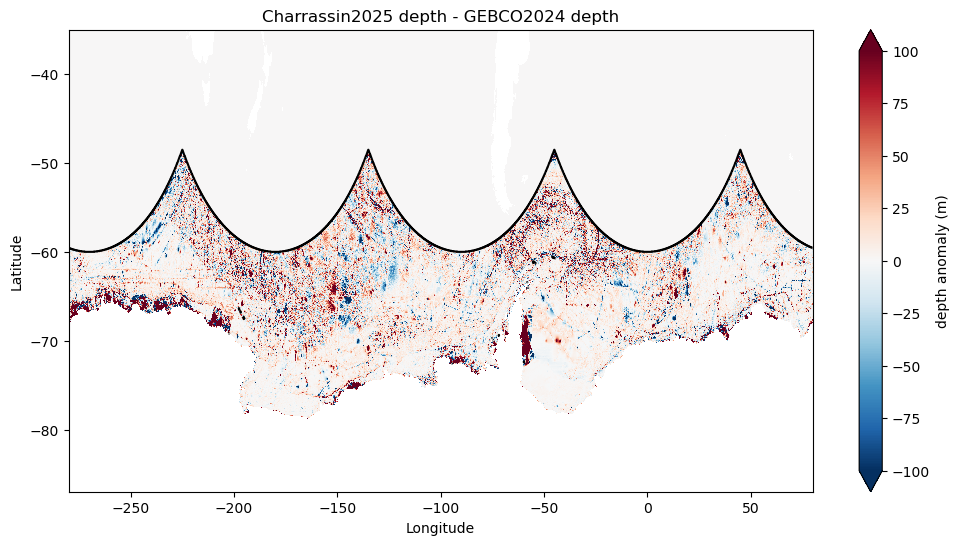

In [20]:
plt.figure(figsize=(12, 6))# You can adjust the width (12) and height (6) as needed
(-Elevation_filled-topog.depth).plot(x='lon', y='lat', vmax = 100, vmin = -100, cmap = 'RdBu_r', cbar_kwargs = {'label':'depth anomaly (m)'})
(Elevation.where(Elevation !=0)*0+1).fillna(0).plot.contour(x='lon', y='lat', levels = [0.5],colors = 'k')
plt.ylim(-87,-35)
#plt.savefig("/g/data1a/tm70/ek4684/Bedmachine_data/elevation_from_Charrassin_on_model_grid.png", dpi=300, bbox_inches='tight')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Charrassin2025 depth - GEBCO2024 depth')

plt.show()


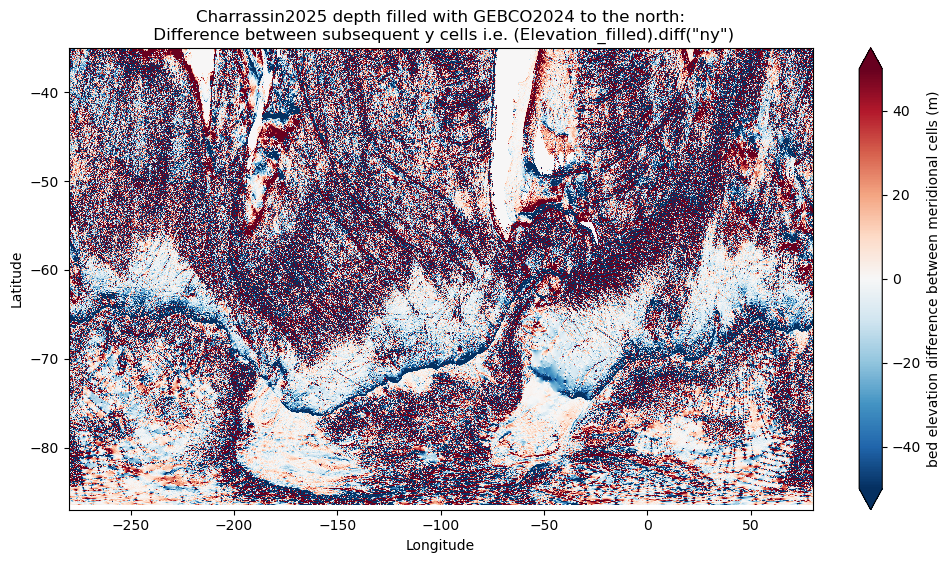

In [29]:
plt.figure(figsize=(12, 6))# You can adjust the width (12) and height (6) as needed
(Elevation_filled).diff('ny').plot(vmax = 50, vmin = -50, cmap = 'RdBu_r', x = 'lon', y = 'lat',cbar_kwargs = {'label':'bed elevation difference between meridional cells (m)'})
plt.ylim(-87,-35)
#plt.savefig("/g/data1a/tm70/ek4684/Bedmachine_data/elevation_from_Charrassin_on_model_grid.png", dpi=300, bbox_inches='tight')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Charrassin2025 depth filled with GEBCO2024 to the north:\n Difference between subsequent y cells i.e. (Elevation_filled).diff("ny")')
plt.show()

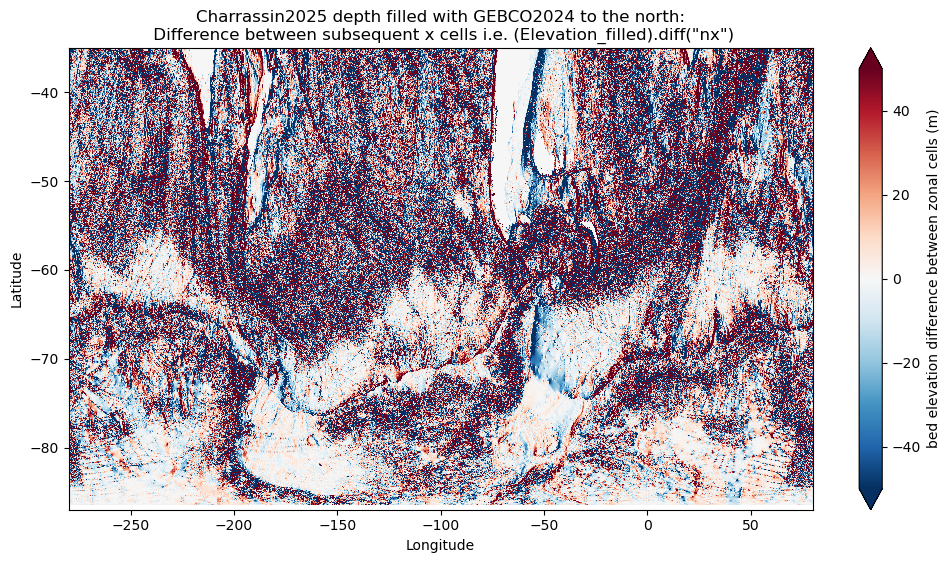

In [30]:
plt.figure(figsize=(12, 6))# You can adjust the width (12) and height (6) as needed
(Elevation_filled).diff('nx').plot(vmax = 50, vmin = -50, cmap = 'RdBu_r', x = 'lon', y = 'lat',cbar_kwargs = {'label':'bed elevation difference between zonal cells (m)'})
plt.ylim(-87,-35)
#plt.savefig("/g/data1a/tm70/ek4684/Bedmachine_data/elevation_from_Charrassin_on_model_grid.png", dpi=300, bbox_inches='tight')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Charrassin2025 depth filled with GEBCO2024 to the north:\n Difference between subsequent x cells i.e. (Elevation_filled).diff("nx")')
plt.show()

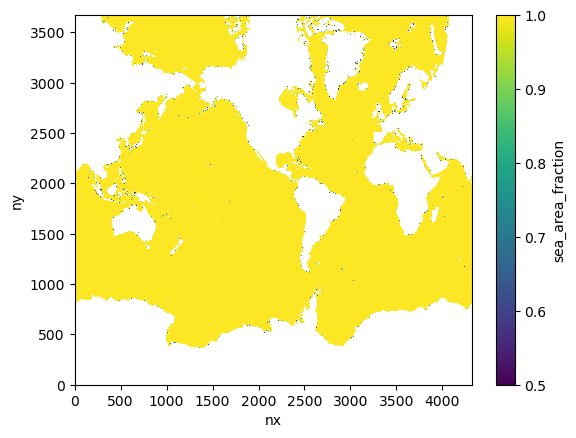

In [19]:
topog.sea_area_fraction.plot()

In [20]:
topog_Charrassin = xr.Dataset(
    data_vars=dict(
        depth=(["ny","nx"], -Elevation_filled.values),
        lat=(["ny","nx"], Elevation_filled.lat.values),
        lon=(["ny","nx"], Elevation_filled.lon.values),           
    ),
    attrs=dict(description="Charrassin 2025 depth regridded onto 8km grid, filled elsewhere with GEBCO 2024 data. Generated with notebook https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/add_charrassin_bathy/generate-draft/Generate-Charrassin-bathy.ipynb "),
)

In [21]:
topog_Charrassin 

<xarray.Dataset> Size: 190MB
Dimensions:  (ny: 3672, nx: 4320)
Dimensions without coordinates: ny, nx
Data variables:
    depth    (ny, nx) float32 63MB 26.02 28.33 30.56 32.58 ... -0.0 -0.0 -0.0
    lat      (ny, nx) float32 63MB -86.49 -86.49 -86.49 ... 65.09 65.05 65.02
    lon      (ny, nx) float32 63MB -280.0 -279.9 -279.8 ... 80.0 80.0 80.0
Attributes:
    description:  Charrassin 2025 depth regridded onto 8km grid, filled to 37...

In [22]:
# save netcdf to gdata
topog_Charrassin.to_netcdf('/g/data/x77/cy8964/mom6/input/input-8km/topog_Charrassin_regridded.nc')

# Repeat for mask and ice shelf

In [14]:
# Open dataset
dataset = gdal.Open('/g/data/x77/cy8964/Charrassin2025_Data/MASK_ANTGG2022.tif')
band = dataset.GetRasterBand(1)
data = band.ReadAsArray()

# Get GeoTransform and projection
gt = dataset.GetGeoTransform()
nx, ny = dataset.RasterXSize, dataset.RasterYSize

# Build coordinates from geotransform
x = np.arange(gt[0], gt[0] + nx * gt[1], gt[1])
y = np.arange(gt[3], gt[3] + ny * gt[5], gt[5])

# y is descending if gt[5] < 0 (common for north-up images), reverse if needed
if gt[5] < 0:
    y = y[::-1]
    data = data[::-1, :]  # Flip data accordingly

da = xr.DataArray(
    data,
    dims=('y', 'x'),
    coords={'x': x, 'y': y},
    attrs={
        'crs': dataset.GetProjection(),
        'transform': gt,
        'nodata': band.GetNoDataValue()
    }
)

ds_xr = xr.Dataset({'mask': da})

# Create 2D coordinate grids
X, Y = np.meshgrid(x, y)

# Flatten and transform
lon_flat, lat_flat = ps_to_ll.transform(X.ravel(), Y.ravel())
lon_flat = (lon_flat + 280) % 360 - 280  # Normalize longitudes

# Reshape to 2D
new_longitudes = lon_flat.reshape(X.shape)
new_latitudes = lat_flat.reshape(Y.shape)

ds_out = xr.Dataset(
    data_vars={
        "mask": (("y", "x"), ds_xr.mask.data)
    },
    coords={
        "lat": (("y", "x"), new_latitudes),
        "lon": (("y", "x"), new_longitudes)
    },
    attrs={
        "title": "Bedmachine Antarctic Topography",
        "source_crs": "EPSG:3031",
        "converted_to": "EPSG:4326",
        "note": "Original Charrassin mask data was in polar stereographic projection and converted to lat/lon."
    }
)

ds_out["mask"].attrs["units"] = "none"
ds_out["mask"].attrs["long_name"] = "Ocean/ice/land mask, byte, 0-5, ocean (0); ice-free land (1); grounded ice (2); floating ice (3); Lake Vostok (4)"
ds_out["lat"].attrs["units"] = "degrees_north"
ds_out["lon"].attrs["units"] = "degrees_east"
#ds_out.to_netcdf("/g/data/x77/cy8964/Charrassin2025_Data/MASK_ANTGG2022_lat_lon.nc")

In [33]:
Charrassin_Mask_data.mask

<xarray.DataArray 'mask' (y: 13333, x: 13333)> Size: 178MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
    lat      (y, x) float64 1GB -48.46 -48.47 -48.47 ... -48.47 -48.47 -48.46
    lon      (y, x) float64 1GB -135.0 -135.0 -135.0 -135.0 ... 44.99 44.99 45.0
Dimensions without coordinates: y, x
Attributes:
    units:      none
    long_name:  Ocean/ice/land mask, byte, 0-5, ocean (0); ice-free land (1);...

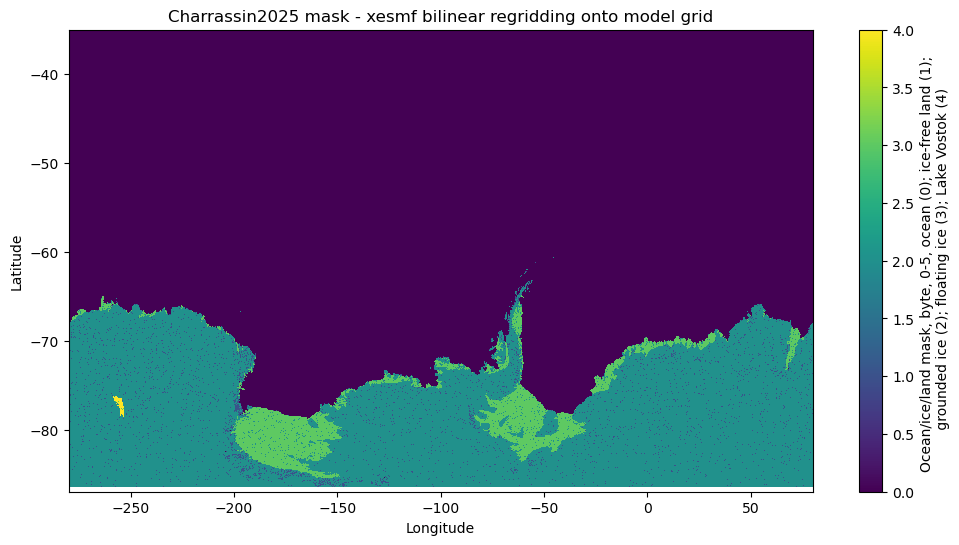

In [34]:
Charrassin_Mask_data = xr.open_dataset('/g/data/x77/cy8964/Charrassin2025_Data/MASK_ANTGG2022_lat_lon.nc', decode_times=False)
#Re-using the weights created for Bedmachine_v3 to model grid, since both the Charrassin and Bedmachine_v3 has same resolution (500m*500m) and same projection EPSG3031.
regridder_Bed_machine_to_GEBCO = xesmf.Regridder(
    Charrassin_Mask_data,
    topog,
    "bilinear",
    periodic=True,
    filename='/g/data/x77/cy8964/mom6/input/input-8km/Regridd_Charrassin_to_8km_global_grid_Bilinear.nc',
    reuse_weights=True)

Mask = regridder_Bed_machine_to_GEBCO(Charrassin_Mask_data.mask)
Mask = Mask.assign_coords(lat=topog['lat'], lon=topog['lon'])
plt.figure(figsize=(12, 6))# You can adjust the width (12) and height (6) as needed
Mask.plot(x='lon', y='lat', cbar_kwargs = {'label':"Ocean/ice/land mask, byte, 0-5, ocean (0); ice-free land (1); \n grounded ice (2); floating ice (3); Lake Vostok (4)"})
plt.ylim(-87,-35)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Charrassin2025 mask - xesmf bilinear regridding onto model grid')

#plt.savefig("/g/data1a/tm70/ek4684/Bedmachine_data/elevation_from_Charrassin_on_model_grid.png", dpi=300, bbox_inches='tight')
plt.show()

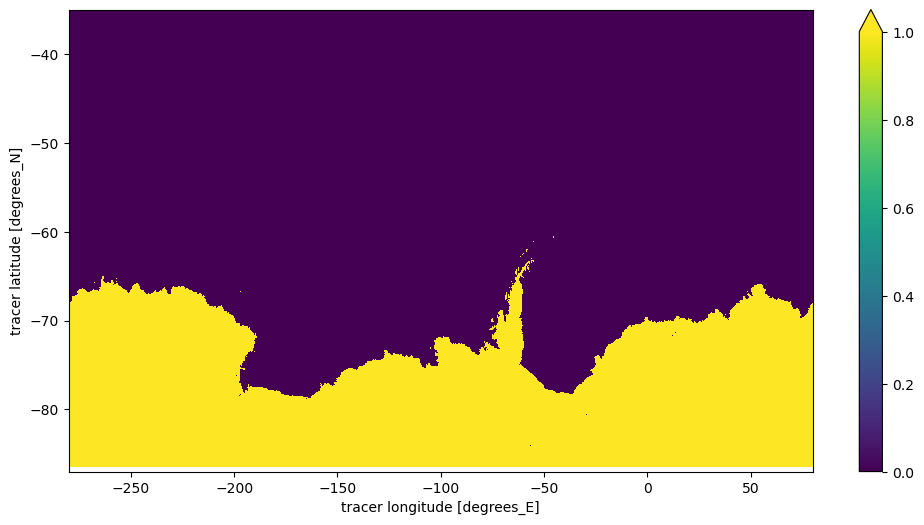

In [16]:
plt.figure(figsize=(12, 6)) #Limit to vmax = 1: still some ocean cells in continent....
Mask.plot(x='lon', y='lat', vmax = 1)
plt.ylim(-87,-35)
#plt.savefig("/g/data1a/tm70/ek4684/Bedmachine_data/elevation_from_Charrassin_on_model_grid.png", dpi=300, bbox_inches='tight')
plt.show()

In [18]:
#load mask consistent with topog.nc
Angus_mask = xr.open_dataset('/g/data/x77/ahg157/inputs/mom6/global-8km/ocean_mask.nc')
Angus_mask

<xarray.Dataset> Size: 127MB
Dimensions:  (ny: 3672, nx: 4320)
Dimensions without coordinates: ny, nx
Data variables:
    mask     (ny, nx) float64 127MB ...
Attributes:
    grid_version:          0.2
    code_release_version:  2024.05
    git_hash:              ffa6ce68b6ec41991973395b895b89e550995786
    creationtime:          Thu Apr 24 10:19:47 2025
    hostname:              rses-049533
    history:               /home/angus/code/repos/FRE-NCtools/tools/make_quic...

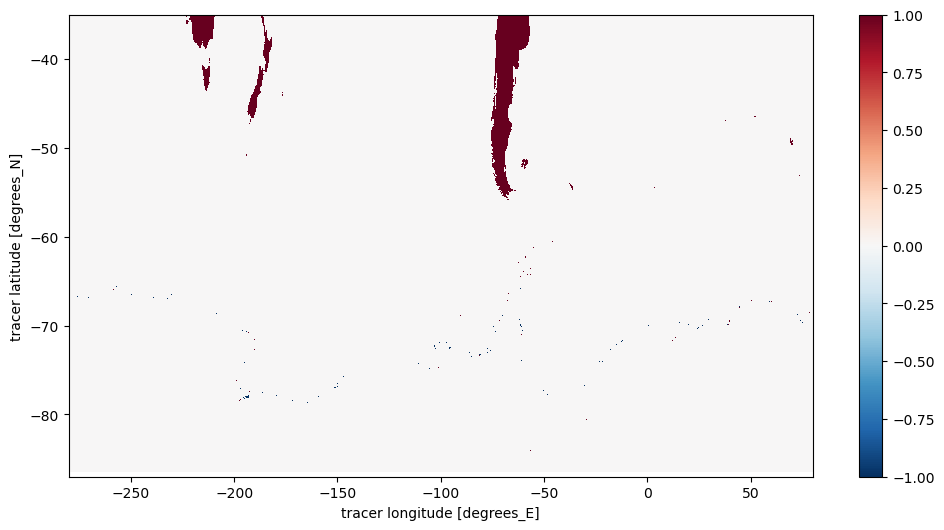

In [19]:
plt.figure(figsize=(12, 6))# You can adjust the width (12) and height (6) as needed
((xr.where(Mask>0.5,0,1))-Angus_mask.mask.values).plot(x='lon', y='lat')
plt.ylim(-87,-35)
#plt.savefig("/g/data1a/tm70/ek4684/Bedmachine_data/elevation_from_Charrassin_on_model_grid.png", dpi=300, bbox_inches='tight')
plt.show()

In [20]:
np.unique(Mask.values)

array([0, 1, 2, 3, 4], dtype=uint8)

Text(0.5, 1.0, 'Original Charrassin mask data')

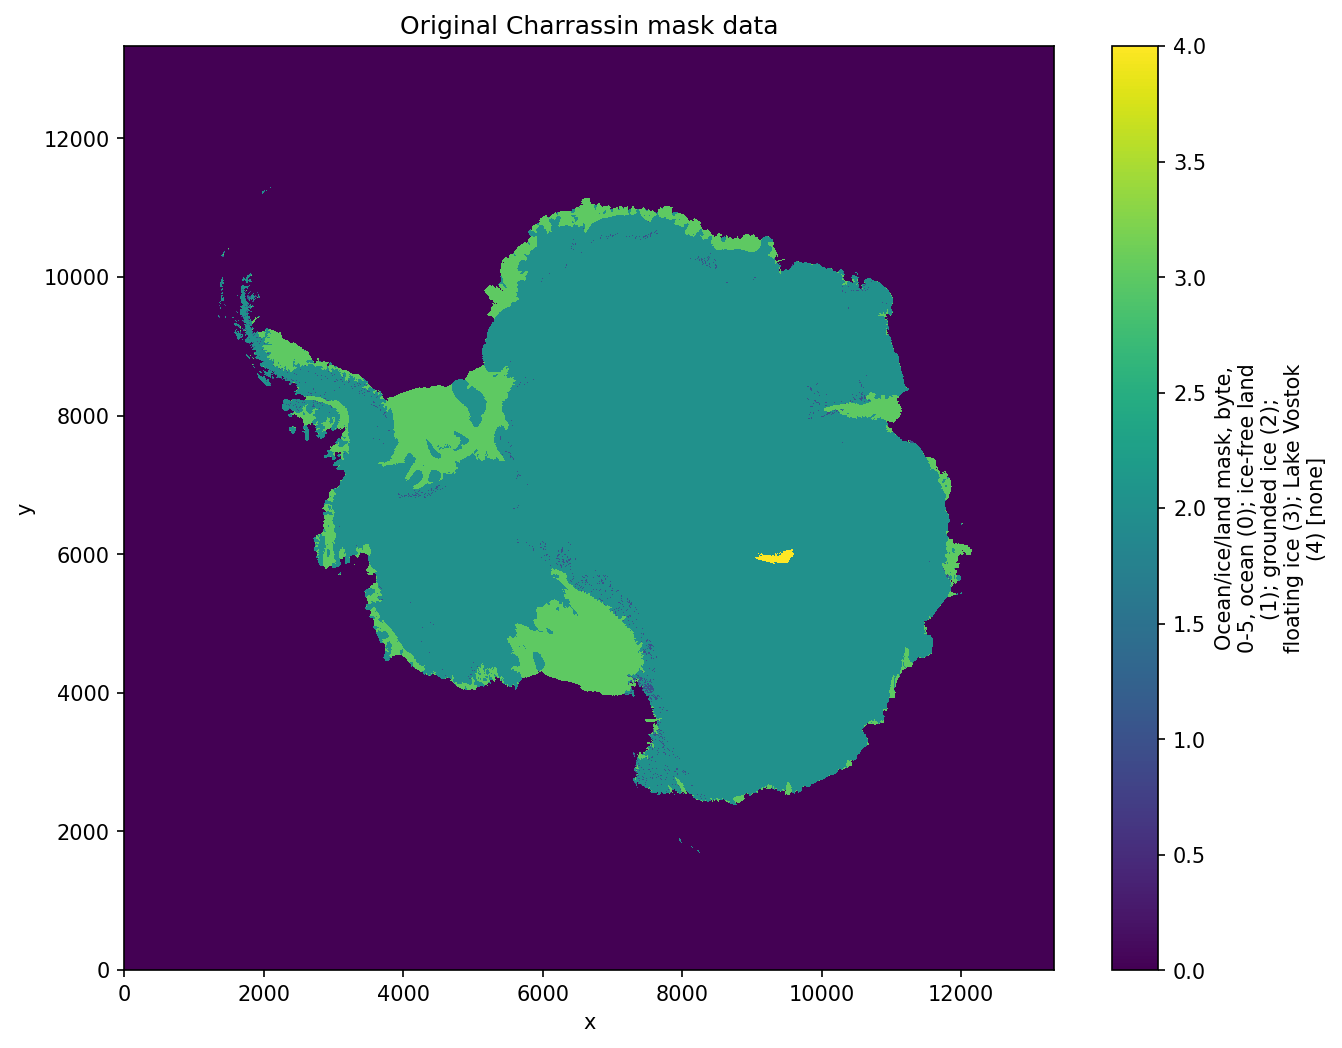

In [32]:
fig = plt.figure(figsize = (10,8), dpi = 150)
Charrassin_Mask_data.mask.plot()
plt.title('Original Charrassin mask data')

# Try nearest neighbour xesmf method

```
mpirun -np 192 ESMF_RegridWeightGen -p none -i --ignore_degenerate -s /g/data/x77/cy8964/Charrassin2025_Data/MASK_ANTGG2022_lat_lon.nc -d /g/data/x77/ahg157/inputs/mom6/global-8km/topog.nc -w /g/data/x77/cy8964/mom6/input/input-8km/Regridd_Charrassin_to_8km_global_grid_NearestNeighbour.nc -m nearestdtos --netcdf4 --src_regional --check

```
this one resulted in values out of range - see nearest_d2s option here https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html

BUT options `neareststod` hangs for an hour, as does `conserve`. Is it really that much more expensive than bilinear?

`neareststod` command:

```
qsub -I -P x77 -q hugemem -l ncpus=192,mem=5880G,walltime=05:00:00,storage=gdata/hh5+gdata/ik11+gdata/x77+gdata/vk83
module load esmf/8.6.1 openmpi/4.1.7
mpirun -np 192 ESMF_RegridWeightGen -p none -i --ignore_degenerate -s /g/data/x77/cy8964/Charrassin2025_Data/MASK_ANTGG2022_lat_lon.nc -d /g/data/x77/ahg157/inputs/mom6/global-8km/topog.nc -w /g/data/x77/cy8964/mom6/input/input-8km/Regridd_Charrassin_to_8km_global_grid_NearestNeighbour_stod.nc -m neareststod --netcdf4 --src_regional --check

In [ ]:
Charrassin_Mask_data = xr.open_dataset('/g/data/x77/cy8964/Charrassin2025_Data/MASK_ANTGG2022_lat_lon.nc', decode_times=False)
#Re-using the weights created for Bedmachine_v3 to model grid, since both the Charrassin and Bedmachine_v3 has same resolution (500m*500m) and same projection EPSG3031.
regridder_Bed_machine_to_GEBCO = xesmf.Regridder(
    Charrassin_Mask_data,
    topog,
    "nearestdtos",
    periodic=True,
    filename='/g/data/x77/cy8964/mom6/input/input-8km/Regridd_Charrassin_to_8km_global_grid_NearestNeighbour.nc',
    reuse_weights=True)

Mask = regridder_Bed_machine_to_GEBCO(Charrassin_Mask_data.mask)
Mask = Mask.assign_coords(lat=topog['lat'], lon=topog['lon'])
plt.figure(figsize=(12, 6))# You can adjust the width (12) and height (6) as needed
Mask.plot(x='lon', y='lat')
plt.ylim(-87,-35)
#plt.savefig("/g/data1a/tm70/ek4684/Bedmachine_data/elevation_from_Charrassin_on_model_grid.png", dpi=300, bbox_inches='tight')
plt.show()

# Ice thickness: bilinear is good

In [25]:
# Open dataset
dataset = gdal.Open('/g/data/x77/cy8964/Charrassin2025_Data/ICE_THICKNESS_ANTGG2022.tif')
band = dataset.GetRasterBand(1)
data = band.ReadAsArray()

# Get GeoTransform and projection
gt = dataset.GetGeoTransform()
nx, ny = dataset.RasterXSize, dataset.RasterYSize

# Build coordinates from geotransform
x = np.arange(gt[0], gt[0] + nx * gt[1], gt[1])
y = np.arange(gt[3], gt[3] + ny * gt[5], gt[5])

# y is descending if gt[5] < 0 (common for north-up images), reverse if needed
if gt[5] < 0:
    y = y[::-1]
    data = data[::-1, :]  # Flip data accordingly

da = xr.DataArray(
    data,
    dims=('y', 'x'),
    coords={'x': x, 'y': y},
    attrs={
        'crs': dataset.GetProjection(),
        'transform': gt,
        'nodata': band.GetNoDataValue()
    }
)

ds_xr = xr.Dataset({'thick': da})

# Create 2D coordinate grids
X, Y = np.meshgrid(x, y)

# Flatten and transform
lon_flat, lat_flat = ps_to_ll.transform(X.ravel(), Y.ravel())
lon_flat = (lon_flat + 280) % 360 - 280  # Normalize longitudes

# Reshape to 2D
new_longitudes = lon_flat.reshape(X.shape)
new_latitudes = lat_flat.reshape(Y.shape)

ds_out = xr.Dataset(
    data_vars={
        "thick": (("y", "x"), ds_xr.thick.data)
    },
    coords={
        "lat": (("y", "x"), new_latitudes),
        "lon": (("y", "x"), new_longitudes)
    },
    attrs={
        "title": "Bedmachine Antarctic Topography",
        "source_crs": "EPSG:3031",
        "converted_to": "EPSG:4326",
        "note": "Original Charrassin ice thickness data was in polar stereographic projection and converted to lat/lon."
    }
)

ds_out["thick"].attrs["units"] = "meters"
ds_out["thick"].attrs["long_name"] = "Ice thickness (meters), float, 0 to 5000 meters."
ds_out["lat"].attrs["units"] = "degrees_north"
ds_out["lon"].attrs["units"] = "degrees_east"
#ds_out.to_netcdf("/g/data/x77/cy8964/Charrassin2025_Data/ICE_THICKNESS_ANTGG2022_lat_lon.nc")

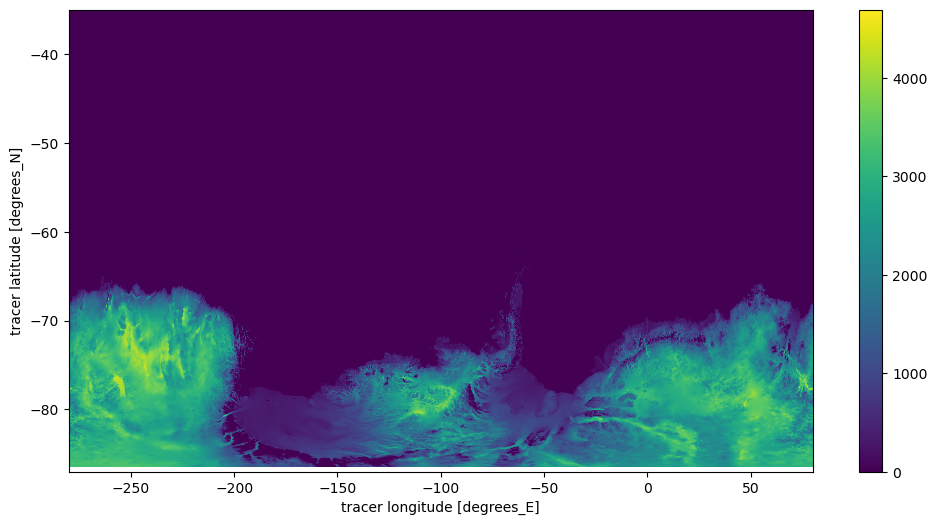

In [26]:
Charrassin_IceThick_data = xr.open_dataset('/g/data/x77/cy8964/Charrassin2025_Data/ICE_THICKNESS_ANTGG2022_lat_lon.nc', decode_times=False)
#Re-using the weights created for Bedmachine_v3 to model grid, since both the Charrassin and Bedmachine_v3 has same resolution (500m*500m) and same projection EPSG3031.
regridder_Bed_machine_to_GEBCO = xesmf.Regridder(
    Charrassin_IceThick_data,
    topog,
    "bilinear",
    periodic=True,
    filename='/g/data/x77/cy8964/mom6/input/input-8km/Regridd_Charrassin_to_8km_global_grid_Bilinear.nc',
    reuse_weights=True)

IceThick = regridder_Bed_machine_to_GEBCO(Charrassin_IceThick_data.thick)
IceThick = IceThick.assign_coords(lat=topog['lat'], lon=topog['lon'])
plt.figure(figsize=(12, 6))# You can adjust the width (12) and height (6) as needed
IceThick.plot(x='lon', y='lat')
plt.ylim(-87,-35)
#plt.savefig("/g/data1a/tm70/ek4684/Bedmachine_data/elevation_from_Charrassin_on_model_grid.png", dpi=300, bbox_inches='tight')
plt.show()